In [41]:
import torch
from torch import nn

import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
import random

from utilities.helper_functions import accuracy_fn

from timeit import default_timer as Timer
# from tqdm.auto import tqdm

from tqdm.autonotebook import tqdm

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

from pathlib import Path

### Device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Initialize accuracy metrics

In [4]:
accuracy_for_train = Accuracy(task='multiclass', num_classes=10).to(device)
accuracy_for_test = Accuracy(task='multiclass', num_classes=10).to(device)

### Caclulate the time of training and testing loop

In [5]:
def print_train_test_time(start, end, device):

    time = end-start
    print(f"Time taken: {time} on {device}")

### Load MNIST data

In [6]:
train_data = MNIST(
    root="datasets/MNIST",
    train=True,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

test_data = MNIST(
    root="datasets/MNIST",
    train=False,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

In [7]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: datasets/MNIST
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: datasets/MNIST
     Split: Test
     StandardTransform
 Transform: ToTensor())

## Let's visualize data

In [8]:
image, label = train_data[0]
classes = train_data.classes
image[0],  classes[label]

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000,

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

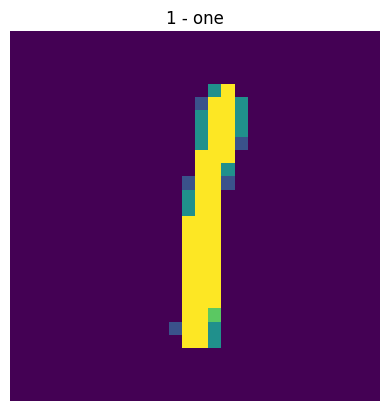

In [9]:
random_index = torch.randint(0, len(train_data), size=[1]).item()
image, label = train_data[random_index]

plt.title(label=classes[label])
plt.imshow(image.squeeze())
plt.axis(False)

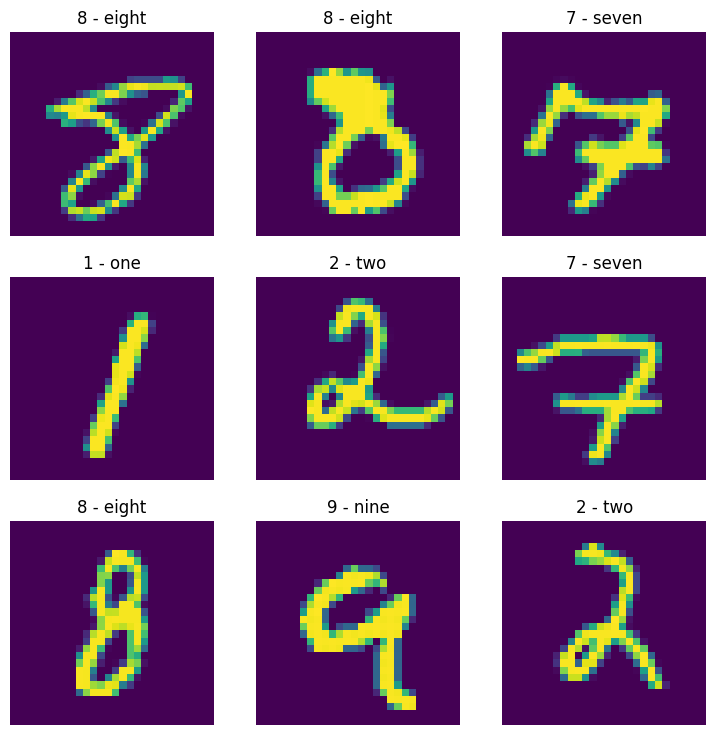

In [10]:
# plot more images

rows, cols = 3, 3

plt.figure(figsize=(9, 9))

for i in range(1, rows * cols + 1):

    random_index = torch.randint(0, len(train_data), size=[1]).item()

    image, label = train_data[random_index]

    plt.subplot(rows, cols, i)

    plt.title(label=classes[label])
    plt.imshow(image.squeeze())
    plt.axis(False)

## Prepare dataloader

In [11]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True,
    pin_memory=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=32,
    pin_memory=True
)

In [12]:

print(f"Length of train dataloader: {len(train_dataloader)} batches of {32}")
print(f"Length of train dataloader: {len(test_dataloader)} batches of {32}")

Length of train dataloader: 1875 batches of 32
Length of train dataloader: 313 batches of 32


In [13]:
train_batch, train_label = next(iter(train_dataloader))
image.shape , label

(torch.Size([1, 28, 28]), 2)

## Plot first batch

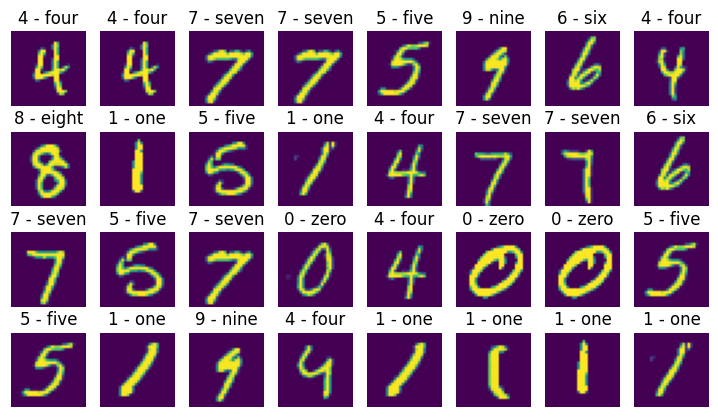

In [14]:
torch.manual_seed(30)

plt.figure(figsize=(9, 5))

rows, cols = 4, 8

for i in range(0, rows*cols):

    random_index = torch.randint(0, len(train_batch), size=[1]).item()

    image, label  = train_batch[random_index], train_label[random_index]

    plt.subplot(rows, cols, i + 1)
    plt.title(label=classes[label])
    plt.imshow(image.squeeze())
    plt.axis(False)

## Build CNN model

In [15]:
class MNISTModelV0(nn.Module):

    def __init__(self, input_shape, hidden_units, output_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.block_1 = nn.Sequential(

            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                        kernel_size=2,
                        stride=2
            )
        )

        self.block_2 = nn.Sequential(

            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)

        return x
    
model_0 = MNISTModelV0(input_shape=1,
                       hidden_units=32,
                       output_shape=10).to(device)

model_0, next(model_0.parameters()).device

(MNISTModelV0(
   (block_1): Sequential(
     (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (block_2): Sequential(
     (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (classifier): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=1568, out_features=10, bias=True)
   )
 ),
 device(type='cuda', index=0))

## Loss function and optimizer

In [16]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.01)

## Let's test the model

In [17]:
train_batch.shape

torch.Size([32, 1, 28, 28])

In [18]:
train_batch = train_batch.to(device)
logits = model_0(train_batch)
preds = logits.argmax(dim=1)

logits, preds

(tensor([[ 6.5595e-03,  1.0007e-02,  1.2086e-02,  2.5639e-02,  1.5962e-02,
           9.6910e-03,  3.0480e-02,  3.0023e-02, -2.8003e-02, -1.3046e-02],
         [ 1.0351e-02, -1.0980e-03,  1.0542e-02,  8.0644e-03,  2.0030e-02,
           2.0212e-02,  3.1363e-02,  2.9523e-02, -2.8589e-02, -2.0332e-02],
         [ 8.5723e-03, -4.4996e-03,  3.6911e-03,  1.3982e-02,  1.9286e-02,
           1.8974e-02,  2.9088e-02,  2.8367e-02, -2.7030e-02, -1.7836e-02],
         [ 4.8934e-03, -4.8689e-03,  9.4316e-03,  2.1292e-02,  2.0647e-02,
           1.7749e-02,  2.8075e-02,  3.1265e-02, -2.7041e-02, -1.7344e-02],
         [ 3.8723e-03, -9.8393e-04,  1.2926e-02,  1.3642e-02,  2.0453e-02,
           2.3557e-02,  3.3800e-02,  3.6134e-02, -2.7532e-02, -2.2603e-02],
         [ 1.0810e-02, -5.1431e-03,  8.4679e-03,  2.9094e-02,  2.0114e-02,
           1.1620e-02,  2.7162e-02,  2.6325e-02, -2.5430e-02, -1.4295e-02],
         [ 3.9229e-03, -5.0820e-03,  2.2412e-02,  1.2332e-02,  2.1705e-02,
           2.7406e-

## Let's build training and testing loop

In [ ]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    
    total_train_loss, total_train_accuracy = 0, 0
    model.to(device)

    accuracy_for_train.reset()

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        model.train()

        train_logits = model(X)
        train_preds = torch.argmax(train_logits, dim=1)
        train_loss = loss_fn(train_logits, y)
        
        accuracy_for_train.update(train_logits, y)

        total_train_loss += train_loss

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        if batch % 400 == 0:

            print(f"samples remaning: {batch*32} / {len(dataloader) * 32}")


    total_train_loss /= len(dataloader)
    total_train_accuracy = accuracy_for_train.compute()


    print(f"Train Loss: {total_train_loss: .5f} --- | Train Accuracy: {total_train_accuracy: .2f}%")


def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device = device):
    
    total_test_loss, total_test_accuracy = 0, 0
    model.to(device)

    accuracy_for_test.reset()

    model.eval()

    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            test_logits = model(X)
            test_preds = torch.argmax(test_logits, dim=1)
            test_loss = loss_fn(test_logits, y)
            accuracy_for_test.update(test_logits, y)

            total_test_loss += test_loss

        total_test_loss /= len(dataloader)
        total_test_accuracy = accuracy_for_test.compute()

    print(f"Test Loss: {total_test_accuracy: .5f} --- | Test Accuracy: {total_test_accuracy: .2f}%")

In [20]:
def fit(model: nn.Module,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        loss_fn: nn.Module,
        optimizer: torch.optim.Optimizer,
        epochs: int,
        device: torch.device = device):
    
    start_time = Timer()
    
    for epoch in tqdm(range(epochs)):

        train_step(model=model,
                   dataloader=train_dataloader,
                   loss_fn=loss_fn,
                   optimizer=optimizer,
                   device=device)
        
        test_step(model=model,
                   dataloader=test_dataloader,
                   loss_fn=loss_fn,
                   device=device)
        
    end_time = Timer()

    print_train_test_time(start_time, end_time, device)

In [32]:
fit(model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=3,
    device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

samples remaning: 0 / 60000
samples remaning: 12800 / 60000
samples remaning: 25600 / 60000
samples remaning: 38400 / 60000
samples remaning: 51200 / 60000
Train Loss:  0.07815 --- | Train Accuracy:  0.98%


 33%|███▎      | 1/3 [00:16<00:33, 16.54s/it]

Test Loss:  0.97930 --- | Test Accuracy:  0.98%
samples remaning: 0 / 60000
samples remaning: 12800 / 60000
samples remaning: 25600 / 60000
samples remaning: 38400 / 60000
samples remaning: 51200 / 60000
Train Loss:  0.06496 --- | Train Accuracy:  0.98%


 67%|██████▋   | 2/3 [00:32<00:16, 16.15s/it]

Test Loss:  0.98260 --- | Test Accuracy:  0.98%
samples remaning: 0 / 60000
samples remaning: 12800 / 60000
samples remaning: 25600 / 60000
samples remaning: 38400 / 60000
samples remaning: 51200 / 60000
Train Loss:  0.05462 --- | Train Accuracy:  0.98%


100%|██████████| 3/3 [00:49<00:00, 16.39s/it]

Test Loss:  0.98210 --- | Test Accuracy:  0.98%
Time taken: 49.169772499997634 on cuda


In [33]:
def eval_model(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
                device: torch.device = device):
    
    total_loss, total_accuracy = 0, 0
    model.to(device)
        
    model.eval()

    with torch.inference_mode():


        accuracy_for_test.reset()
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            logits = model(X)
            pred = torch.argmax(logits, dim=1)
            loss = loss_fn(logits, y)
            total_accuracy += accuracy_fn(pred, y)
            accuracy_for_test.update(logits, y)

            total_loss += loss
        
        total_loss /= len(dataloader)
        total_accuracy = accuracy_for_train.compute()
    return {
        "model_name": model.__class__.__name__,
        "model_loss": total_loss.item(),
        "model_accuracy": total_accuracy.item()
    }


In [34]:
def make_predictions(model: nn.Module,
                     test_sample,
                     device: torch.device = device):

    preds = []    
    model.to(device)

    model.eval()

    with torch.inference_mode():

        for sample in test_sample:

            sample = sample.to(device)

            logits = model(sample.unsqueeze(dim=1))
            pred = torch.softmax(logits, dim=1).argmax(dim=1)
            preds.append(pred.cpu())

    return preds

In [35]:
def make_predictions_on_dataloader(model: nn.Module,
                                   dataloader: torch.utils.data.DataLoader,
                                   device: torch.device = device):
    
    y_preds = []

    model.eval()

    with torch.inference_mode():

        for X, y in tqdm(dataloader, desc="Making predictions"):

            X, y = X.to(device), y.to(device)

            y_logits = model(X)

            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

            y_preds.append(y_pred.cpu())

    return y_preds

In [36]:
def plot_predictions(model: nn.Module,
                     samples: int,
                     test_data=test_data,
                     device: torch.device = device):
    
    test_sample = []
    test_label = []

    for X, y in random.sample(list(test_data), k = samples):

        test_sample.append(X)
        test_label.append(y)

    preds = torch.concat(make_predictions(model=model,
                     test_sample=test_sample,
                     device=device))
    
    plt.figure(figsize=(16, 30))

    rows, cols = 8, 5

    for i in range(1, samples + 1):

        random_index = torch.randint(0, len(test_sample), size=[1])

        image = test_sample[random_index]
        label = test_label[random_index]

        pred_label = classes[preds[random_index]]
        truth_label = classes[label]

        title = f"Pred: {pred_label} | Truth: {truth_label}"

        plt.subplot(rows, cols, i)

        if pred_label == truth_label:

            plt.title(label=title, c="g")
        else:

            plt.title(label=title, c='r')

        plt.imshow(image.squeeze())
        plt.axis(False)

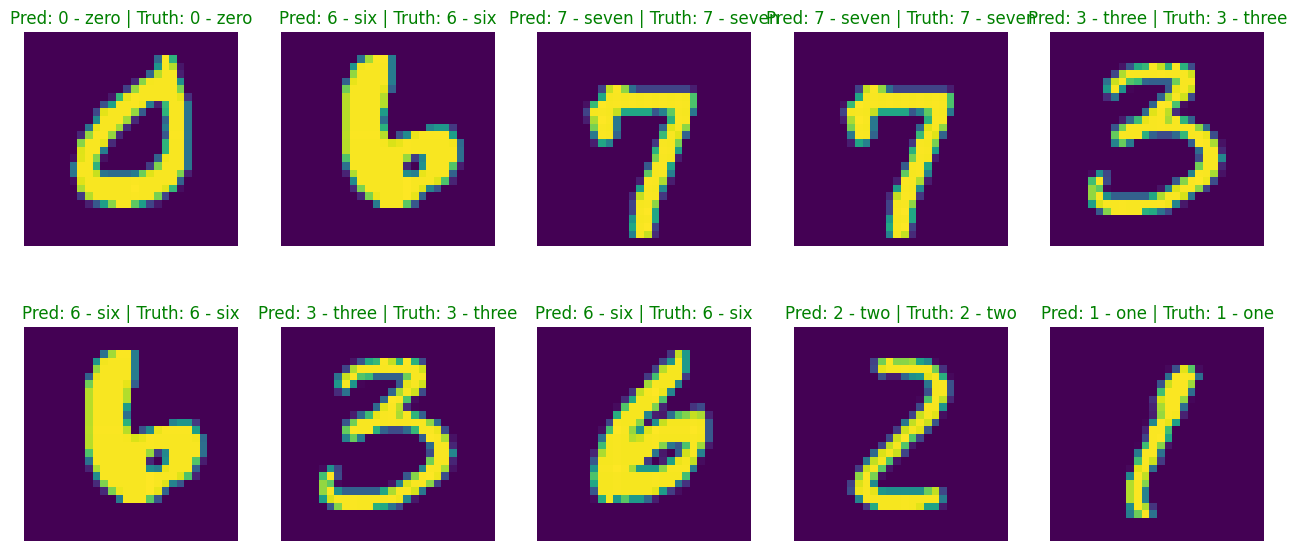

In [37]:
plot_predictions(model=model_0, samples=10)

In [38]:
model_0_results = eval_model(model_0, test_dataloader, loss_fn, device)
model_0_results

{'model_name': 'MNISTModelV0',
 'model_loss': 0.05608464777469635,
 'model_accuracy': 0.9835166931152344}

In [39]:
y_pred = torch.concat(make_predictions_on_dataloader(model=model_0, dataloader=test_dataloader, device=device))
y_pred[:5]

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 183.00it/s]


tensor([7, 2, 1, 0, 4])

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

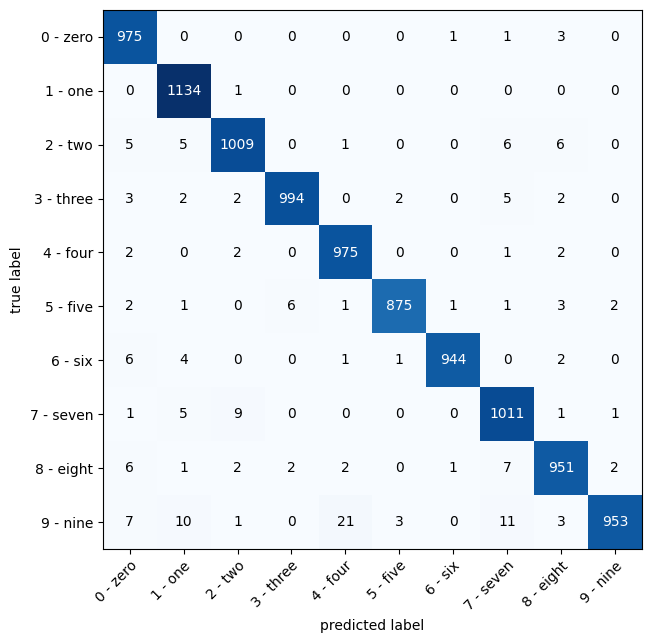

In [40]:
comfat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
comfat_tensor = comfat(preds=y_pred,
                       target = test_data.targets)

plot_confusion_matrix(conf_mat=comfat_tensor.numpy(),
                      figsize=(10, 7),
                      class_names=classes)

### Model_1

In [27]:
class MNISTModelV1(nn.Module):

    def __init__(self, input_shape, hidden_units, output_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.layer_stack = nn.Sequential(

            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),           
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),           
            nn.Linear(in_features=hidden_units, out_features=output_shape)            
        )

    def forward(self, x:torch.tensor) -> torch.tensor:

        return self.layer_stack(x)
    
model_1 = MNISTModelV1(
    input_shape=28*28,
    hidden_units=32,
    output_shape=10
).to(device)

model_1

MNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)

### test model

In [28]:
image, label = test_data[0]
image.shape, label

(torch.Size([1, 28, 28]), 7)

In [29]:
image = image.to(device)
logits = model_1(image)
logits

tensor([[-0.0318,  0.1107,  0.1488,  0.1210,  0.0909, -0.2574, -0.0633,  0.0319,
          0.0263, -0.1966]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Loss function and optimizer

In [30]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

### Train model

In [31]:
fit(model=model_1,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=5,
    device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

samples remaning: 0 / 60000
samples remaning: 12800 / 60000
samples remaning: 25600 / 60000
samples remaning: 38400 / 60000
samples remaning: 51200 / 60000
Train Loss:  1.12841 --- | Train Accuracy:  0.70%


 20%|██        | 1/5 [00:15<01:01, 15.35s/it]

Test Loss:  0.87360 --- | Test Accuracy:  0.87%
samples remaning: 0 / 60000
samples remaning: 12800 / 60000
samples remaning: 25600 / 60000
samples remaning: 38400 / 60000
samples remaning: 51200 / 60000
Train Loss:  0.40289 --- | Train Accuracy:  0.89%


 40%|████      | 2/5 [00:31<00:47, 15.68s/it]

Test Loss:  0.89980 --- | Test Accuracy:  0.90%
samples remaning: 0 / 60000
samples remaning: 12800 / 60000
samples remaning: 25600 / 60000
samples remaning: 38400 / 60000
samples remaning: 51200 / 60000
Train Loss:  0.33713 --- | Train Accuracy:  0.90%


 60%|██████    | 3/5 [00:48<00:33, 16.52s/it]

Test Loss:  0.90910 --- | Test Accuracy:  0.91%
samples remaning: 0 / 60000
samples remaning: 12800 / 60000
samples remaning: 25600 / 60000
samples remaning: 38400 / 60000
samples remaning: 51200 / 60000
Train Loss:  0.30042 --- | Train Accuracy:  0.91%


 80%|████████  | 4/5 [01:03<00:15, 15.95s/it]

Test Loss:  0.92000 --- | Test Accuracy:  0.92%
samples remaning: 0 / 60000
samples remaning: 12800 / 60000
samples remaning: 25600 / 60000
samples remaning: 38400 / 60000
samples remaning: 51200 / 60000
Train Loss:  0.27227 --- | Train Accuracy:  0.92%


100%|██████████| 5/5 [01:19<00:00, 15.96s/it]

Test Loss:  0.92970 --- | Test Accuracy:  0.93%
Time taken: 79.82182130000729 on cuda


In [32]:
model_1_results = eval_model(model=model_1,
                             dataloader=test_dataloader,
                             loss_fn=loss_fn,
                             device=device)
model_1_results

{'model_name': 'MNISTModelV1',
 'model_loss': 0.25055399537086487,
 'model_accuracy': 0.9229999780654907}

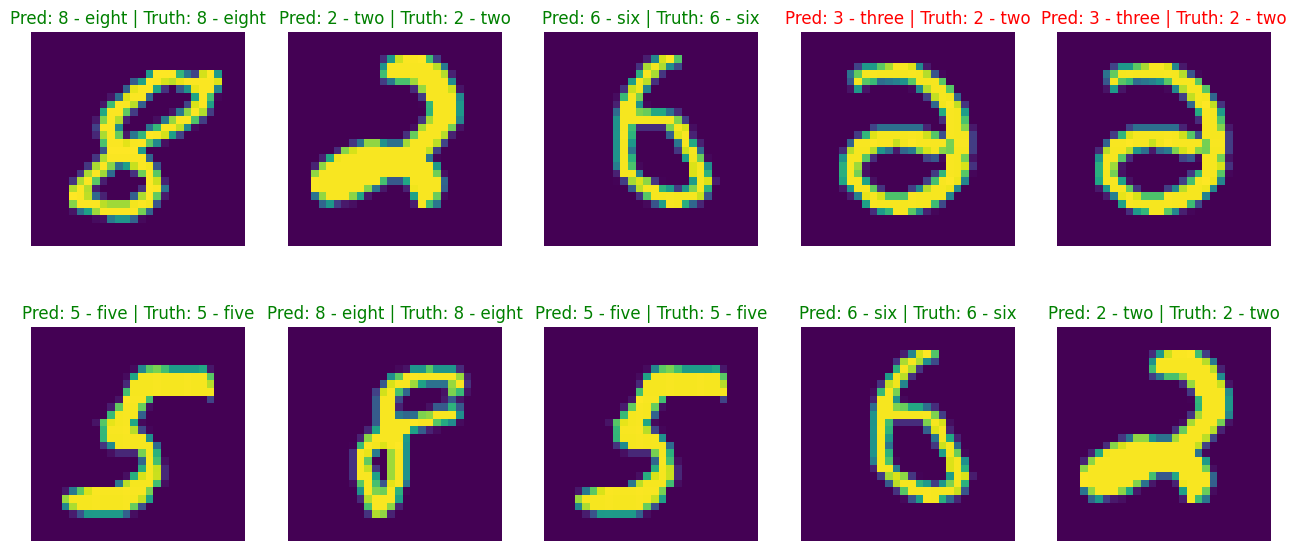

In [33]:
plot_predictions(model=model_1,
                 samples=10)

In [34]:
y_preds = torch.concat(make_predictions_on_dataloader(model=model_1,
                               dataloader=test_dataloader,
                               device=device))

y_preds

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 188.32it/s]


tensor([7, 2, 1,  ..., 4, 5, 6])

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

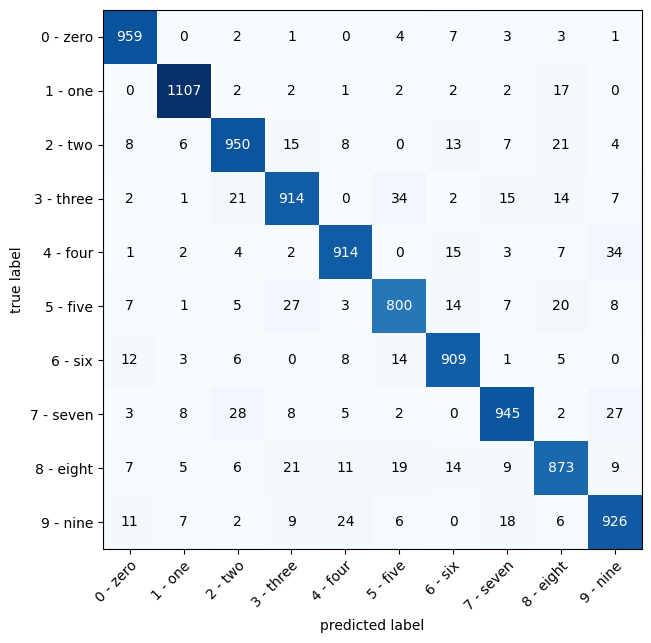

In [35]:
confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=y_preds,
                         target=test_data.targets)

plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                      class_names=classes,
                      figsize=(10, 7))

### Save model 0

In [43]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = '08-PyTorch-Computer-Vision-MNIST.pt'
MODE_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model at: {MODE_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODE_SAVE_PATH)

Saving model at: models\08-PyTorch-Computer-Vision-MNIST.pt


In [49]:
loaded_model_0 = MNISTModelV0(input_shape=1,
                              hidden_units=32,
                              output_shape=10)

loaded_model_0.load_state_dict(torch.load(MODE_SAVE_PATH))

<All keys matched successfully>

In [50]:
eval_model(model=loaded_model_0, loss_fn=loss_fn, dataloader=test_dataloader)

{'model_name': 'MNISTModelV0',
 'model_loss': 0.05608464777469635,
 'model_accuracy': 0.9835166931152344}